In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [4]:
class Indicator:

    currentConnectionNumber = 0
    startStopMap = {}
    levelHeightMap = {}
    vLineStartMap = {}

    def __init__(self,length,ax,artists,datarange):
        # length represents the number of boxes, columns in array
        self.datarange = datarange
        self.grid = np.zeros((1,length))
        self.baseHeights = self.getBaseHeight(artists)
        self.calcHeightForLevel(0)
    
    def newConnections(self,connections):
         for connection in connections:
            self.newConnection(connection[0],connection[1])

    def newConnection(self,start,stop):
        # this checks if the space is avalible at the current height.
        # If not create new row
        # Also add the connection after check
        currentLevel = 0
        while any([pos for pos in self.grid[currentLevel][start:stop+1]]):
                currentLevel += 1
                if currentLevel == self.grid.shape[0]: self.addLevel(currentLevel)
        self.startStopMap[self.currentConnectionNumber] = {"start":start,"stop":stop, "level":currentLevel}
        self.addConnectionOnLevel(currentLevel,start,stop)
        self.currentConnectionNumber += 1
    
    def addConnectionOnLevel(self,height,start,stop):
        # this should block rows in self.grid according to passed positions
        for i in range(start,stop+1):
            self.grid[height][i] = self.currentConnectionNumber+1
    
    def addLevel(self,level):
        # this simply adds a new Row
        self.grid = np.vstack((self.grid, np.zeros((1,self.grid.shape[1]))))
        self.calcHeightForLevel(level)

    def calcHeightForLevel(self,level):
        # this should calculate the height of each level on the axes
        # The miniumum height for all connections on lvl 0 should be above all artist components
        if level==0: self.levelHeightMap[level] = np.max(self.baseHeights) + self.datarange/10
        else: self.levelHeightMap[level] = self.levelHeightMap[level-1] + self.datarange/10

    def getBaseHeight(self,artists):
        baseHeighs = []
        upperWhiskers = [whisker for i,whisker in enumerate(artists["whiskers"]) if i%2]
        for flier,whisker in zip(artists["fliers"],upperWhiskers):
            flierHeight = flier.get_path().get_extents().y1
            whiskerHeight = whisker.get_path().get_extents().y1
            print(flierHeight,whiskerHeight)
            baseHeighs.append(*[flierHeight if flierHeight != -np.inf else whiskerHeight])
        return baseHeighs

    def calcHeightForVlines(self):
        # this puts the startheights of each vertical line in a second grid
        # This is dependend on baseHeights and the height levels of the existing grid if a spot underneath is blocked
        startHeightMap_levels = {level:{} for level in self.startStopMap}
        startHeightMap = {level:{} for level in self.startStopMap}
        for connectionIndex, connection in self.startStopMap.items():
            for vLine in [connection["start"],connection["stop"]]:
                level = connection["level"]
                while level != 0:
                    if self.grid[level-1][vLine]:
                        break
                    level -= 1
                startHeightMap_levels[connectionIndex][vLine] = level
        for connectionIndex,connection in startHeightMap_levels.items():
            for vLineX,level in connection.items():
                if level == 0: 
                    startHeightMap[connectionIndex][vLineX] = self.baseHeights[vLineX]
                else:
                    startHeightMap[connectionIndex][vLineX] = self.levelHeightMap[level]-0.5
        return startHeightMap


    def drawConnection(self,ax,artists):
        # this simply draws the connection
        vLineStartHeight = self.calcHeightForVlines()
        print(vLineStartHeight)
        topWhiskers = [whisker for i,whisker in enumerate(artists["whiskers"]) if i%2==0]
        for connectionIndex, connection in self.startStopMap.items():
            startX = topWhiskers[connection["start"]].get_path().get_extents().x0
            endX = topWhiskers[connection["stop"]].get_path().get_extents().x0
            height = self.levelHeightMap[connection["level"]]
            ax.plot([startX,endX],[height,height])
            for boxIndex,conY in vLineStartHeight[connectionIndex].items():
                # Change how X-Pos is calculated
                ax.plot([boxIndex+1,boxIndex+1],[conY,height])
            
        

6.0 3.0
-inf 2.0
-inf 4.0
5.0 2.0
-inf 6.0
-inf 3.0
-inf 2.0
-inf 5.0


TypeError: slice indices must be integers or None or have an __index__ method

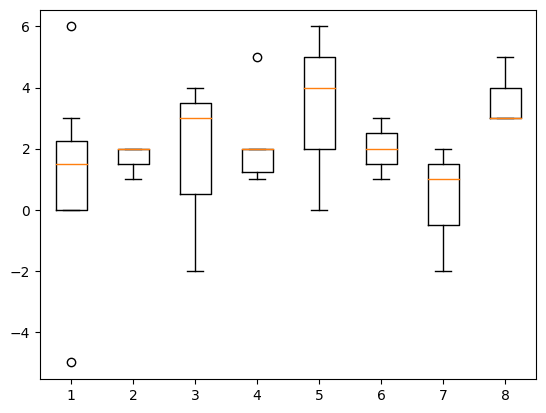

In [5]:
fig = plt.figure()
ax = fig.add_subplot()
artist = ax.boxplot([
    [-5,0,1,2,2,0,3,6],
    [1,2,2],
    [-2,4,3],
    [1,2,2,2,1,5],
    [0,4,6],
    [1,2,3],
    [-2,2,1],
    [3,5,3,3,4]
])

ind = Indicator(len(artist["boxes"]),ax,artist,10)
ind.newConnections([
    (1,3),
    (2,5),
    (1,6),
    (4,5)
])
print(ind.grid)
print(ind.levelHeightMap)
print(ind.startStopMap)
print(ind.baseHeights)
ind.drawConnection(ax,artist)
plt.show()

In [236]:
{i:path.get_path().get_extents().y1 for i,path in enumerate(artist["whiskers"])}

{0: 0.5,
 1: 3.0,
 2: 1.5,
 3: 2.0,
 4: 0.5,
 5: 4.0,
 6: 1.25,
 7: 2.0,
 8: 2.0,
 9: 6.0,
 10: 1.5,
 11: 3.0,
 12: -0.5,
 13: 2.0,
 14: 3.0,
 15: 5.0}